 # Training a Quantum Model on a Real Dataset
 
 Reference: Qiskit.org

In [1]:
from sklearn.datasets import load_iris

iris_data = load_iris()

In [2]:
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

There are a few interesting observations we can find from this dataset description:

There are 150 samples (instances) in the dataset.

There are four features (attributes) in each sample.

There are three labels (classes) in the dataset.

The dataset is perfectly balanced, as there are the same number of samples (50) in each class.

We can see features are not normalized, and their value ranges are different, e.g., 
 and 
 for sepal length and petal width, respectively. So, transforming the features to the same scale may be helpful.

As stated in the table above, feature-to-class correlation in some cases is very high; this may lead us to think that our model should cope well with the dataset.

In [3]:
features = iris_data.data
labels = iris_data.target

Firstly, we’ll normalize the features. Namely, we will apply a simple transformation to represent all features on the same scale. In our case, we squeeze all features onto the interval 
. Normalization is a common technique in machine learning and often leads to better numerical stability and convergence of an algorithm.

We can use MinMaxScaler from scikit-learn to perform this. Without specifying parameters, this does exactly what is required: maps data onto [0, 1].

In [4]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

Let’s see how our data looks. We plot the features pair-wise to see if there’s an observable correlation between them.

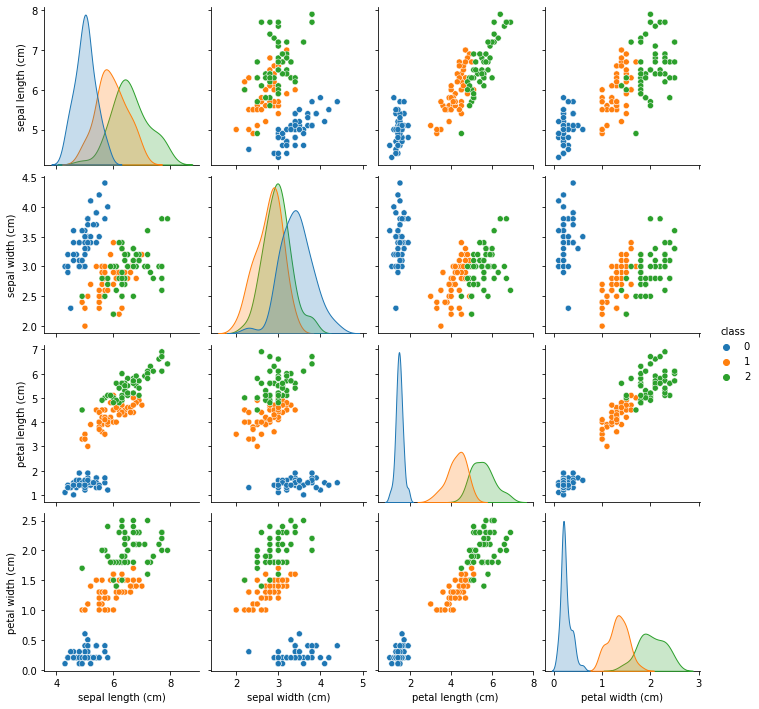

In [5]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

## Applying a Quantum Machine Learning Model

Our choice of feature map will be the ZZFeatureMap. The ZZFeatureMap is one of the standard feature maps in the Qiskit circuit library. We pass num_features as feature_dimension, meaning the feature map will have num_features or 4 qubits.

In [15]:
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed)

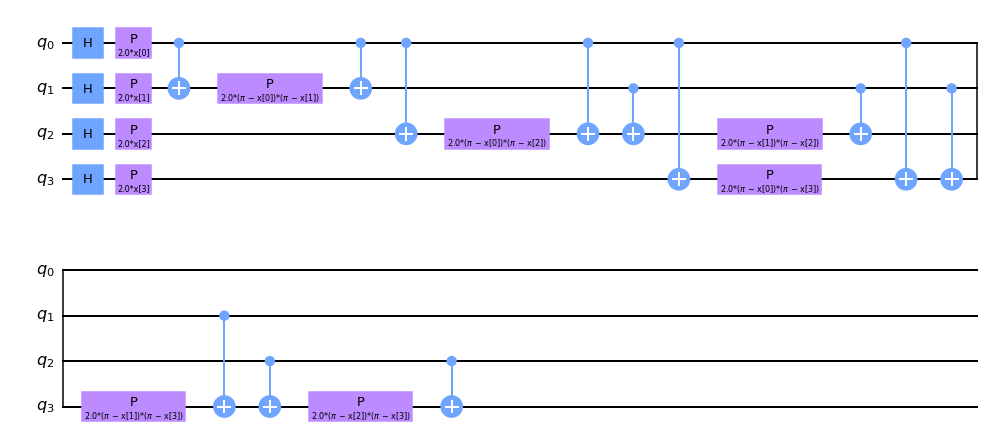

In [6]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

If you look closely at the feature map diagram, you will notice parameters x[0], ..., x[3]. These are placeholders for our features.

Now we create and plot our ansatz. Pay attention to the repetitive structure of the ansatz circuit. We define the number of these repetitions using the reps parameter.

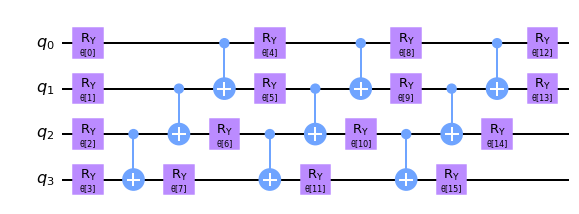

In [7]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

This circuit has 16 parameters named θ[0], ..., θ[15]. These are the trainable weights of the classifier.

We then choose an optimization algorithm to use in the training process. This step is similar to what you may find in classical deep learning frameworks. To make the training process faster, we choose a gradient-free optimizer. You may explore other optimizers available in Qiskit.

In [9]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In the next step, we define where to train our classifier. We can train on a simulator or a real quantum computer. Here, we will use a simulator. We create an instance of the Sampler primitive. This is the reference implementation that is statevector based. Using qiskit runtime services you can create a sampler that is backed by a quantum computer.

In [12]:
from qiskit.primitives import Sampler

sampler = Sampler()

We will add a callback function called callback_graph. VQC will call this function for each evaluation of the objective function with two parameters: the current weights and the value of the objective function at those weights. Our callback will append the value of the objective function to an array so we can plot the iteration versus the objective function value. The callback will update the plot at each iteration. Note that you can do whatever you want inside a callback function, so long as it has the two-parameter signature we mentioned above.

In [10]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Now we are ready to construct the classifier and fit it.

VQC stands for “variational quantum classifier.” It takes a feature map and an ansatz and constructs a quantum neural network automatically. In the simplest case it is enough to pass the number of qubits and a quantum instance to construct a valid classifier. You may omit the sampler parameter, in this case a Sampler instance will be created for you in the way we created it earlier. We created it manually for illustrative purposes only.

Training may take some time. Please, be patient.

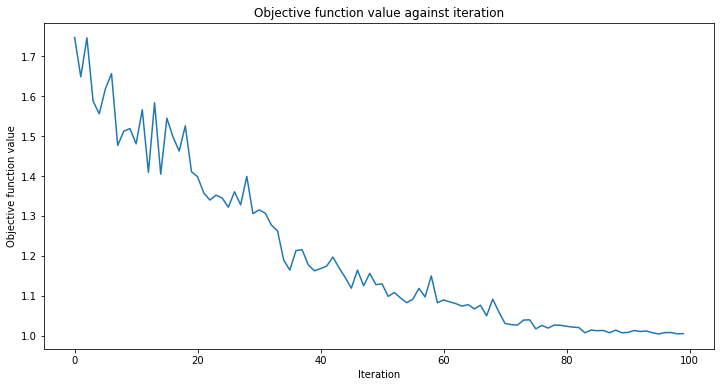

Training time: 52 seconds


In [16]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [17]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.85
Quantum VQC on the test dataset:     0.87


## Question 2

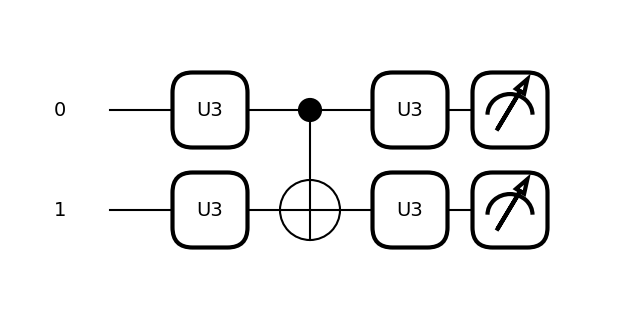

Expectation value: 0.3607270760765955


In [7]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Define a two qubit device
dev = qml.device("default.qubit", wires=2)

# Define the variational quantum circuit using pennylane
@qml.qnode(dev)
def circuit(params):
    # Apply U3 gates for rotation on the first and second qubit
    #each U3 circuit needs 3 parameters
    qml.U3(params[0], params[1], params[2], wires=0)
    qml.U3(params[3], params[4], params[5], wires=1)
    
    # Entangle the qubits using a CNOT gate
    qml.CNOT(wires=[0, 1])
    
    # Apply U3 gates for rotation again
    qml.U3(params[6], params[7], params[8], wires=0)
    qml.U3(params[9], params[10], params[11], wires=1)
    
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

# Initialize random parameters for the U3 circuit. 
# each U3 circuit needs 3 parameters, therefore a total of 12 parameters is needed
params = np.random.rand(12)

# Print the circuit
fig, ax = qml.draw_mpl(circuit)(params)
plt.show()

# Evaluate the circuit
result = circuit(params)
print("Expectation value:", result)
